In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [15]:
df=pd.read_csv("./btc.csv")
df.head()

,PriceUSD
0,0.085840
1,0.080800
2,0.074736
3,0.079193
4,0.058470


In [16]:
data = pd.DataFrame(df["PriceUSD"])
data['returns'] = np.log(data/data.shift(1))
#data['returns'].iloc[1200:1700].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [19]:
"""
data_train = pd.DataFrame(df["CVX"].iloc[0:1000])
data_train['returns'] = np.log(data_train/data_train.shift(1))
data_train
data_test = pd.DataFrame(df["CVX"].iloc[1000:1700])
data_test['returns'] = np.log(data_test/data_test.shift(1))
data_test
data_train.dropna(inplace=True)
data_test.dropna(inplace=True)
"""
data = pd.DataFrame(df["PriceUSD"])
data['returns']=np.log(data/data.shift(1))


In [21]:
#data = pd.DataFrame(df["PriceUSD"].iloc[0:1200])
#data['returns'] = np.log(data/data.shift(1))

In [22]:
data['MA20']=data['PriceUSD'].rolling(window=20).mean()
#data['MA30']=data['PriceUSD'].rolling(window=30).mean()
#data['MA50']=data['PriceUSD'].rolling(window=50).mean()
data['MA90']=data['PriceUSD'].rolling(window=90).mean()
data['MA131']=data['PriceUSD'].rolling(window=131).mean()

In [23]:
data.dropna(inplace=True)

In [24]:
data['MA_deriv']=data['MA90']-data['MA90'].shift(1)

In [41]:
data.dropna(inplace=True)
data.head()

,PriceUSD,returns,MA20,MA90,MA131,MA_deriv,pfolio_MA_deriv,ret_MA_deriv
131,0.284400,0.015592,0.266706,0.135826,0.113506,0.002442,1,0.015592
132,0.283000,-0.004935,0.263856,0.138259,0.115050,0.002433,0,-0.000000
133,0.271359,-0.042005,0.265265,0.140552,0.116551,0.002293,0,-0.000000
134,0.230559,-0.162933,0.265929,0.142447,0.117706,0.001895,0,-0.000000
135,0.208200,-0.102010,0.264862,0.144072,0.118849,0.001624,0,-0.000000


In [26]:
print(data['MA_deriv'].mean())

2.8092885617384096


In [27]:
data['pfolio_MA_deriv']=1
buf=1
for index, row in data.iterrows():
    data.at[index, 'pfolio_MA_deriv']=buf
    if row["MA_deriv"]<0.01:
        buf=0
    else:
        buf=1

In [28]:
data['ret_MA_deriv']=data['returns']*data['pfolio_MA_deriv']

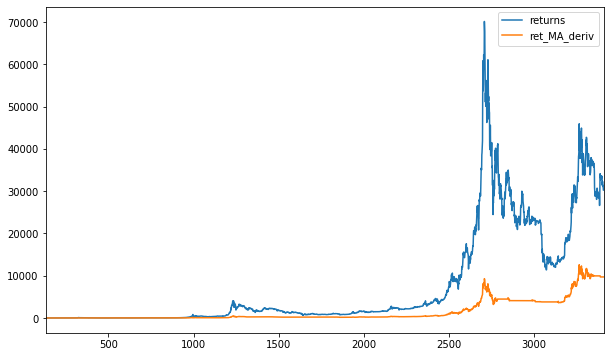

In [29]:
data[['returns', 'ret_MA_deriv']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))

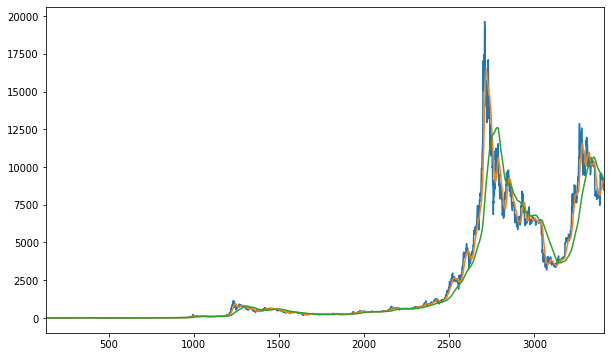

In [31]:
data['PriceUSD'].plot(figsize=(10, 6))
data['MA20'].plot()
data['MA90'].plot()
plt.show()

In [32]:
data['ret_MA_deriv'].cumsum().apply(np.exp).iloc[-1]

9707.910471605752

In [33]:
def compute_ret_MA(df, stock):
    res=0
    best_MA=0
    for i in range(10,100):
        data = pd.DataFrame(df[stock].iloc[2600:2701])
        data['returns'] = np.log(data/data.shift(1))
        data['MA']=data[stock].rolling(window=i).mean()
        data.dropna(inplace=True)
        data['MA_deriv']=data['MA'].pct_change()
        data.dropna(inplace=True)
        
        data['pfolio_MA_deriv']=1
        buf=1
        for index, row in data.iterrows():
            data.at[index, 'pfolio_MA_deriv']=buf
            if row["MA_deriv"]<0:
                buf=0
            else:
                buf=1
        data['ret_MA_deriv']=data['returns']*data['pfolio_MA_deriv']
       # print(data['ret_MA_deriv'])
        tmp=data['ret_MA_deriv'].cumsum().apply(np.exp).iloc[-1]
        #print(i)
        if (res<tmp):
            res=tmp
            best_MA=i
        #print(i, best_MA, res)
    return res, best_MA

In [34]:
def best_MA(df, stock):
    res=0
    data = pd.DataFrame(df[stock].iloc[200:400])
    data['returns'] = np.log(data/data.shift(1))
    for i in range (101, len(data)):
        for j in range(10,20):
            data['MA']=data[stock].iloc[i-100:i].rolling(window=j).mean()
            data['MA_deriv']=data['MA'].pct_change()
            data['pfolio_MA_deriv']=1
            buf=1
            for index, row in data.iterrows():
                data.at[index, 'pfolio_MA_deriv']=buf
                if row["MA_deriv"]<0:
                    buf=0
                else:
                    buf=1
            data['ret_MA_deriv']=data['returns']*data['pfolio_MA_deriv']
            tmp=data['ret_MA_deriv'].cumsum().apply(np.exp).iloc[-1]
            if (res<tmp):
                res=tmp
                best_MA=i
            data.loc[j,'bestMA']=best_MA            
    return data

In [42]:
datafinal=best_MA(df, 'PriceUSD')
datafinal.head()

,PriceUSD,returns,MA,MA_deriv,pfolio_MA_deriv,ret_MA_deriv,bestMA
200,0.693898,NaN,NaN,NaN,1,NaN,NaN
201,0.810959,0.155892,NaN,NaN,1,0.155892,NaN
202,0.911671,0.117062,NaN,NaN,1,0.117062,NaN
203,0.898000,-0.015110,NaN,NaN,1,-0.015110,NaN
204,0.889421,-0.009599,NaN,NaN,1,-0.009599,NaN


In [43]:
res, MA=compute_ret_MA(df, 'PriceUSD')
print(res, MA)

4.433329656624974 16


In [44]:
def result_MA(df, MA, stock):
    data = pd.DataFrame(df[stock].iloc[1500:])
    data['returns'] = np.log(data/data.shift(1))
    data['MA']=data[stock].rolling(window=MA).mean()
    #data['MA']=data[stock].iloc[2500:2700].rolling(window=37).mean()
    data.dropna(inplace=True)
    #data['MA_deriv']=data['MA']-data['MA'].shift(2)
    data['MA_deriv']=data['MA'].pct_change()
    data.dropna(inplace=True)    
    buf=1
    for index, row in data.iterrows():
        data.at[index, 'pfolio_MA_deriv']=buf
        if row["MA_deriv"]<0:
            buf=0
        else:
            buf=1
    #data['returns_final']=data['returns'].iloc[500:1700]
    data['ret_MA_deriv']=data['returns']*data['pfolio_MA_deriv']
    print('ret_MA ',data['ret_MA_deriv'].cumsum().apply(np.exp).iloc[-1])
    data[['returns', 'ret_MA_deriv']].cumsum().apply(np.exp).plot(figsize=(10, 6))
    plt.show()    
    data['MA'].plot(figsize=(10,6))
    data[stock].plot()
    plt.show()

ret_MA  45.75218689567363


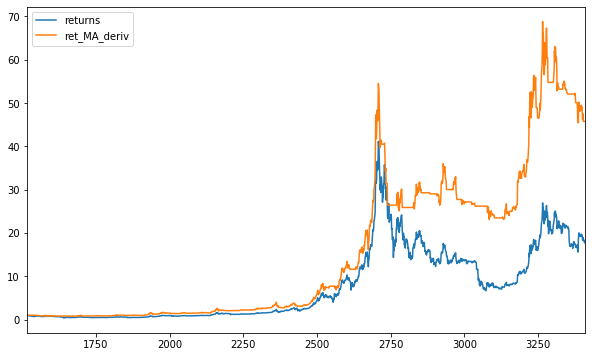

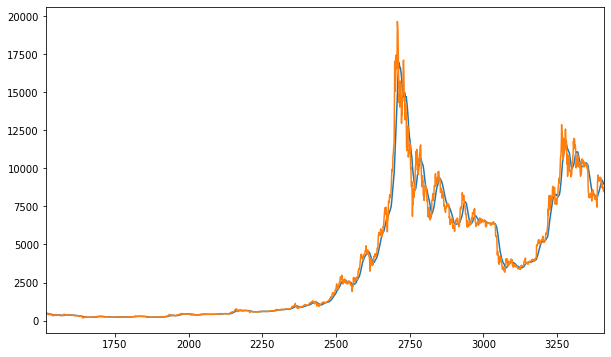

In [45]:
result_MA(df, 16, 'PriceUSD')

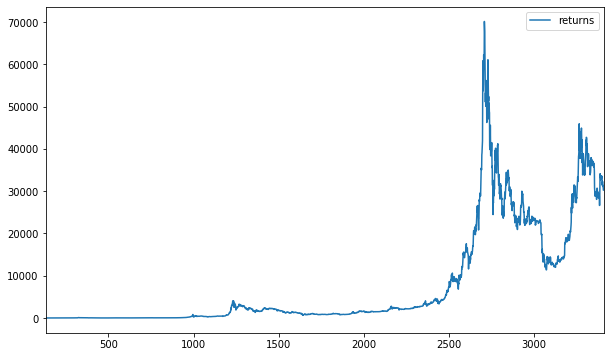

In [39]:
data[['returns']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [40]:
print(data.loc[2,"PriceUSD"])

KeyError: 2